In [1]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,

    Random,
    StatsBase
;

using Distributions, Interpolations

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_diffusion.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"

;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [2]:
package = get_CaOH_package();
package_A = get_CaOH_package_12_A_states();
n_states = length(package.states)
n_excited = package.n_excited;

In [3]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end

get_Δ_from_exp (generic function with 1 method)

In [4]:
function get_ODT_Hamiltonian_matrix(package, package_A, peak_intensity, pol, wavelength=1064e-9)
    Is = π*h*c*Γ/(3λ^3) / 10 # saturation intensity in mW/cm^2
    s = peak_intensity / Is
    f_ODT = c/wavelength 
    
    n_states = length(package.states)
    E0 = sqrt(s)/(2 * √2) # factor?
    H_ODT = zeros(ComplexF64, n_states, n_states)
    
    d = package_A.d
    fs = energy.(package_A.states)

    
    for q in 1:3
        for p in 1:3
            
            for i in 1:n_states
                for j in 1:n_states
                    for l in 1:length(package_A.states)
                    H_ODT[i,j] -= 2π * Γ * (E0^2/4 * d[min(i,l),max(i,l),q] * pol[q] * d[min(j,l),max(j,l),p] * pol[p]) * 
                                    (1/(fs[l]-fs[i] - f_ODT) + 1/(fs[l]-fs[i] + f_ODT))
                    end
                end
            end
            
        end
    end
    
    return H_ODT
end

function particles_in_ODT(results)
    indicies = []
    number = 0.0
   for i in 1:length(results.x_trajectories)
        if abs(results.x_trajectories[i][end]) < 0.05 && abs(results.z_trajectories[i][end]) < 0.05 
            push!(indicies, i)
            number += exp(-results.photons_scattered[i]/14000)
        end 
    end
    return number, indicies
end

function generate_sequence!(sequence, timing)
    t_last = 0.0
    i_last = 1
   for params in sequence
        params.t_start = t_last
        params.t_end = t_last + timing[i_last]
        t_last = t_last + timing[i_last]
        i_last += 1
    end
end


# function get_ODT_Hamiltonian_matrix(package, peak_intensity, pol, wavelength=1064e-9)
#     H_ODT = zeros(ComplexF64, n_states, n_states)
#     for i in 1:16
#         H_ODT[i,i] = -1.0
#     end
#     return H_ODT
# end

generate_sequence! (generic function with 1 method)

In [5]:
# α = 4 # number of revoltions
# r_max = 60e-6 #m
# t_max = 40e-3 #s

# n = 1000
# arclengths = zeros(n)
# # spiral: r = τ; theta = 2πα * τ
# τs = LinRange(0,1,n)
# dτ = τs[2]-τs[1]
# length_curr = 0.0

# for i in 1:n
#     r = r_max/1 * τs[i]
#     θ = 2*π * α * τs[i]
#     length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
#     arclengths[i] = length_curr
# end

# velocity = length_curr / t_max
# ts = arclengths / velocity
# func_t_to_τ = linear_interpolation(ts,τs, extrapolation_bc=Flat());



# function update_ODT_center!(p, t1)::Nothing
#     if t1 >= p.ODT_motion_t_start*Γ
#         t = min(t1/Γ - p.ODT_motion_t_start,  p.ODT_motion_t_stop -p.ODT_motion_t_start )
#         iτ = searchsortedfirst(p.interpolation_times,t)
#         τ = p.interpolation_τs[iτ] + (p.interpolation_τs[iτ+1]-p.interpolation_τs[iτ])/(p.interpolation_times[iτ+1]-p.interpolation_times[iτ])*(t-p.interpolation_times[iτ])
#         # τ = func_t_to_τ(t)
#         p.ODT_position[1] = p.r_max * τ * cos(2*π*τ* p.α)
#         p.ODT_position[2] = p.r_max * τ * sin(2*π*τ* p.α)
#     end
#     return nothing
# end


# # plot see the ODT path
# ts_plot = LinRange(0,30e-3, 100).*Γ
# xs = zeros(100)
# ys = zeros(100)
# p = MutableNamedTuple(ODT_motion_t_start = 0.0, ODT_motion_t_stop = 40e-3, r_max = r_max, α=α, Γ=Γ, ODT_position = [0.0,0.0],
#     interpolation_times = ts, interpolation_τs = τs)

# for i in 1:100
#     update_ODT_center!(p, ts_plot[i])
#     xs[i] = p.ODT_position[1]
#     ys[i] = p.ODT_position[2]
# end
# plot(xs.*1e6, ys.*1e6)

In [13]:
s = s1 + s3 + s4;
1/6*s^(3/2) 

2.999815529128443

In [16]:
1/120*s^(3/2) * 5

0.7499538822821108

In [44]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end

temp = @with_unit 1.00 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.01, 0.01, 0.01]*1e-3
kick = [0,0, 0.0, 0.0]
 

s2 = 0.0; Δ2 = 0.0; B_gradient = 75; ramp_time = 4e-3

detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)

intensity_voltage = 0.7
power_total = intensity_voltage * 13.1 # mW

p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4

s = s1 + s3 + s4
# voltages = 0.3:0.2:2.1
# s_mult_scan = voltages * (34.6 / 3.4) /s
;

blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 100,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,
                                pol_imbalance=0.05, 
                                s_imbalance = (0.2, 0.2, -0.2), retro_loss=0.2, 

                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.05, 0.05, 0.0,0.0,0,0],

                                ODT_intensity = 13.3*1e3/(50e-4)^2*0,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                C3 = 50.0,
                                C5 = 5.0,
                                C7 = 0.0)

molecules_in_ODT_params = deepcopy(blue_MOT_params)
molecules_in_ODT_params.t_start = 0.0
molecules_in_ODT_params.t_end = 2e-3
molecules_in_ODT_params.s1 = molecules_in_ODT_params.s2 = molecules_in_ODT_params.s3 = molecules_in_ODT_params.s4 = 0.0
molecules_in_ODT_params.B_gradient = 0.0
molecules_in_ODT_params.displacement = [0.0,0.0,0.0]
molecules_in_ODT_params.diameter = 100e-6
molecules_in_ODT_params.ODT_intensity = 13.3*1e3/(50e-4)^2
molecules_in_ODT_params.ODT_motion_t_start = 0.0



SF_cooling_params = deepcopy(blue_MOT_params)
SF_cooling_params.s2 = SF_cooling_params.s3 = SF_cooling_params.s4 = 0.0
SF_cooling_params.s1 = 5.0 
SF_cooling_params.Δ1 = 45 * 1e6 * 2π #(57 - 7.4*(5.5-2)) * 1e6 * 2π
SF_cooling_params.s_ramp_to_factor = 1.0
SF_cooling_params.B_gradient = 0.0
SF_cooling_params.Bz_offset = 0.15
SF_cooling_params.ODT_intensity = 13.3*1e3/(50e-4)^2



drop_cloud_params = deepcopy(molecules_in_ODT_params)

sequence = [blue_MOT_params]
durations = [5e-3]
generate_sequence!(sequence, durations)
SF_cooling_params.ODT_motion_t_start = SF_cooling_params.t_start 
SF_cooling_params.ODT_motion_t_stop = SF_cooling_params.t_end  
drop_cloud_params.ODT_motion_t_start = SF_cooling_params.t_start
drop_cloud_params.ODT_motion_t_stop = SF_cooling_params.t_end

# test_i = log_test_info(working_dir,1,blue_MOT_params)
@time results = simulate_particles_ODT(package, package_A, sequence, variable_budget=true);
# save_results(working_dir, test_i, results)

# trapped_number, trapped_indicies = particles_in_ODT(results)
# @printf("ODT loading = %.1f / %i", trapped_number, sequence[1].n_values)
# @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:26

 86.734600 seconds (166.66 k allocations: 34.547 MiB)


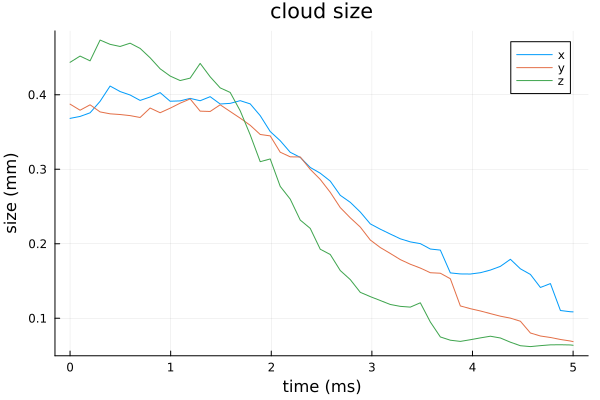

In [59]:
plot_size(results, "all")
plot!()

In [60]:
size, error = bootstrap_size_fit(results; iter=100)
size

0.06299593271001142

In [61]:
signal, error = bootstrap_survival(results, iter=100)
signal

0.4564997271066482

In [62]:
t_end = 5e-3
temp, error = bootstrap_temperature_fit(results, iter=100, range=1)
temp

108.10790721870433

0.13026002907923814
0.11555064870554642
116.37701358145755


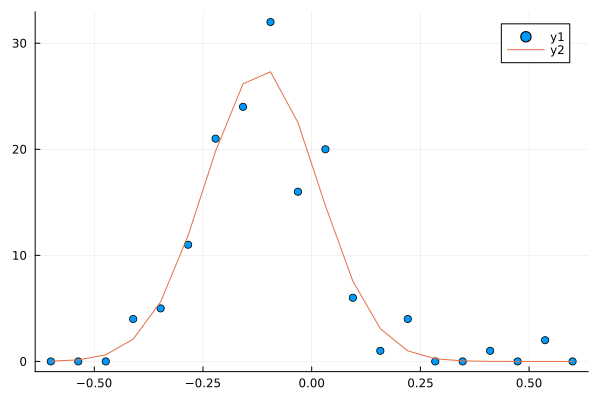

In [75]:
n_values = 200
t_end = 5e-3

sizes = []
x_grid = collect(LinRange(-0.6, 0.6, 20))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived(t_end, results1.times)

xs = [results1.x_velocities[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

println(fit.param[2])
println(plot_size(results1, "x")[2][end])
    println(m * fit.param[2]^2 /k_B *1e6)

# println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))

1.2790032608695652e6

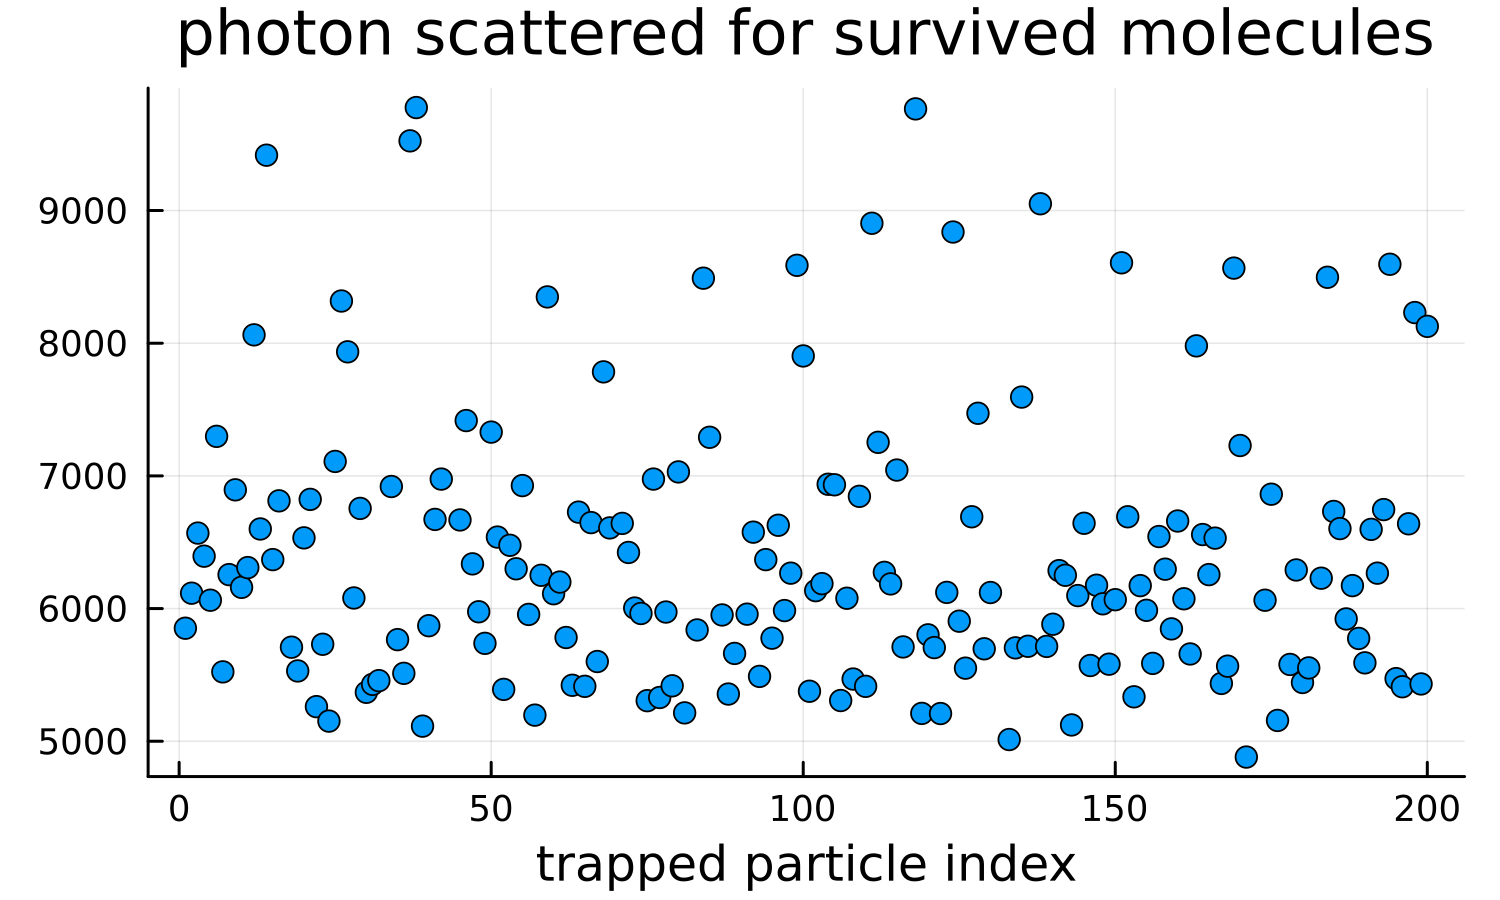

In [36]:
print(plot_photons_scattered(results)/5e-3)

plot!()

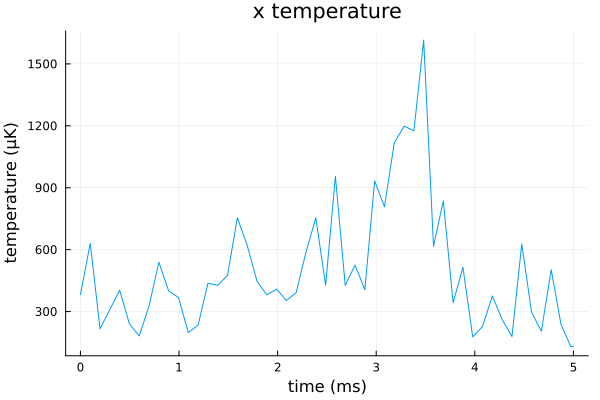

In [149]:
plot_temperature(results, "x")

plot!()

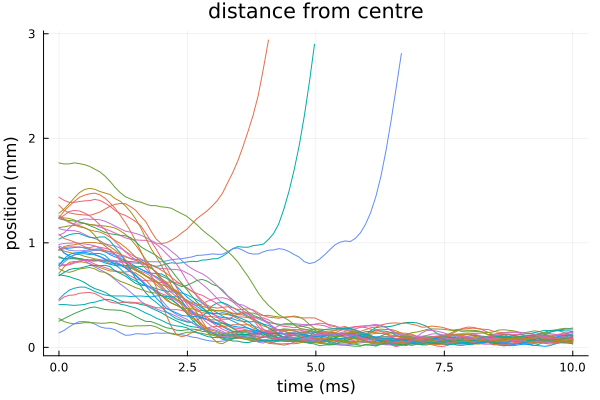

In [37]:
plot_all_trajectories(results, "all")

plot!()

0.308249409285323


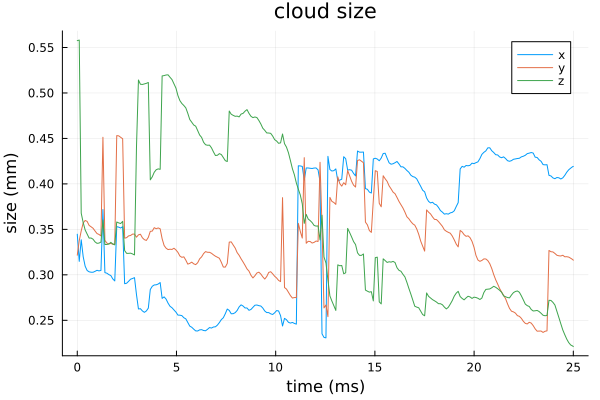

In [82]:
_,sx, sy, sz = temp = plot_size(results, "all")
println((sx[end]*sy[end]*sz[end])^(1/3))
plot!()

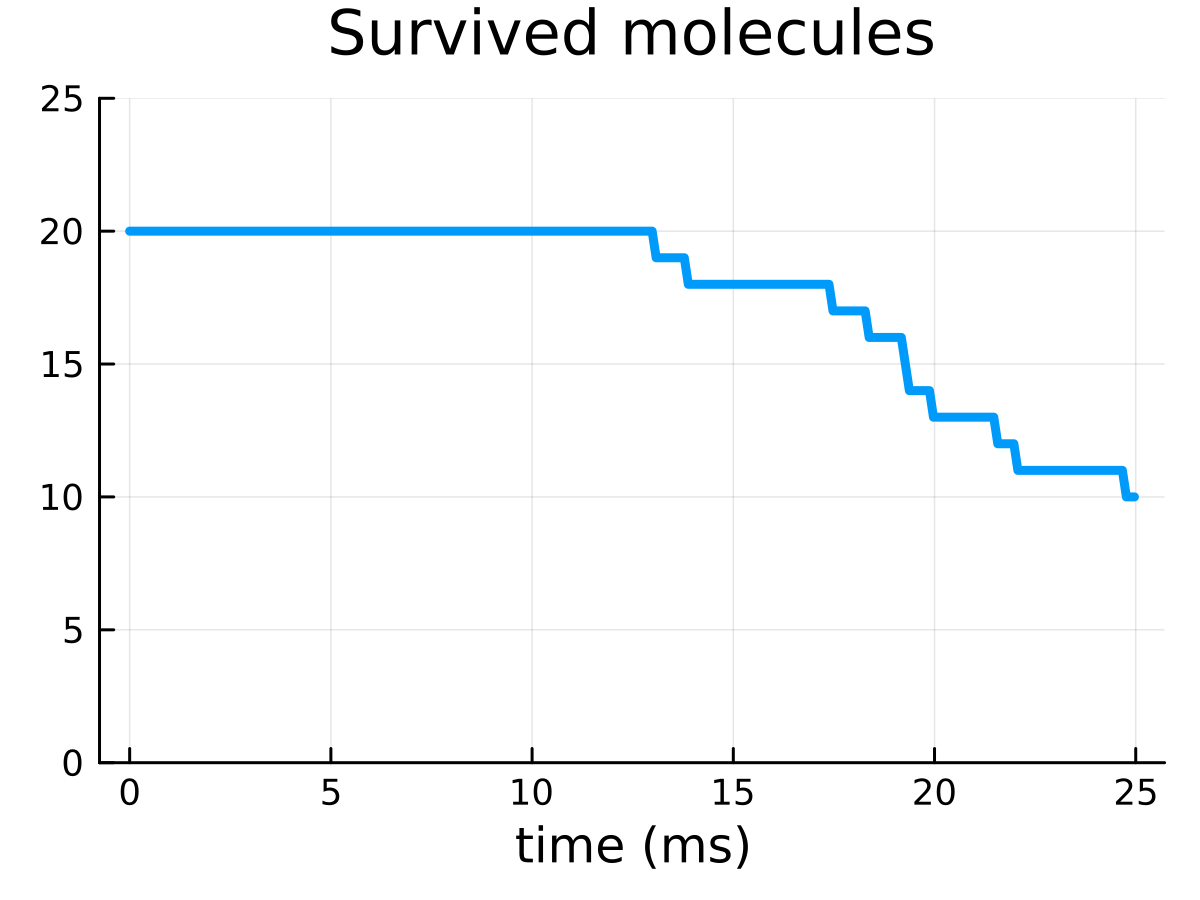

In [77]:
plot_survival(blue_MOT_params,results)
plot!()

1.3069653873493696


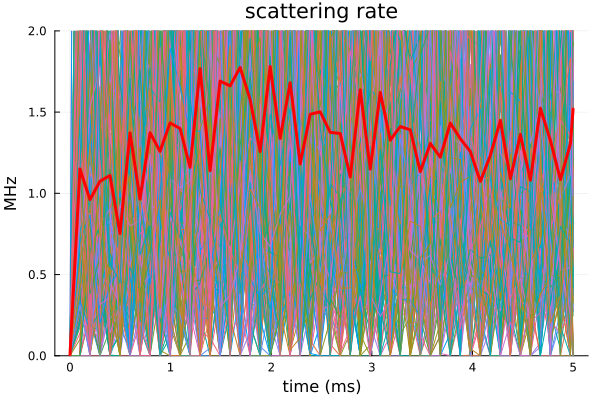

In [173]:
println(plot_scattering_rate(results))
plot!(ylim=[0,2])

In [98]:
# results_no_shift = results;

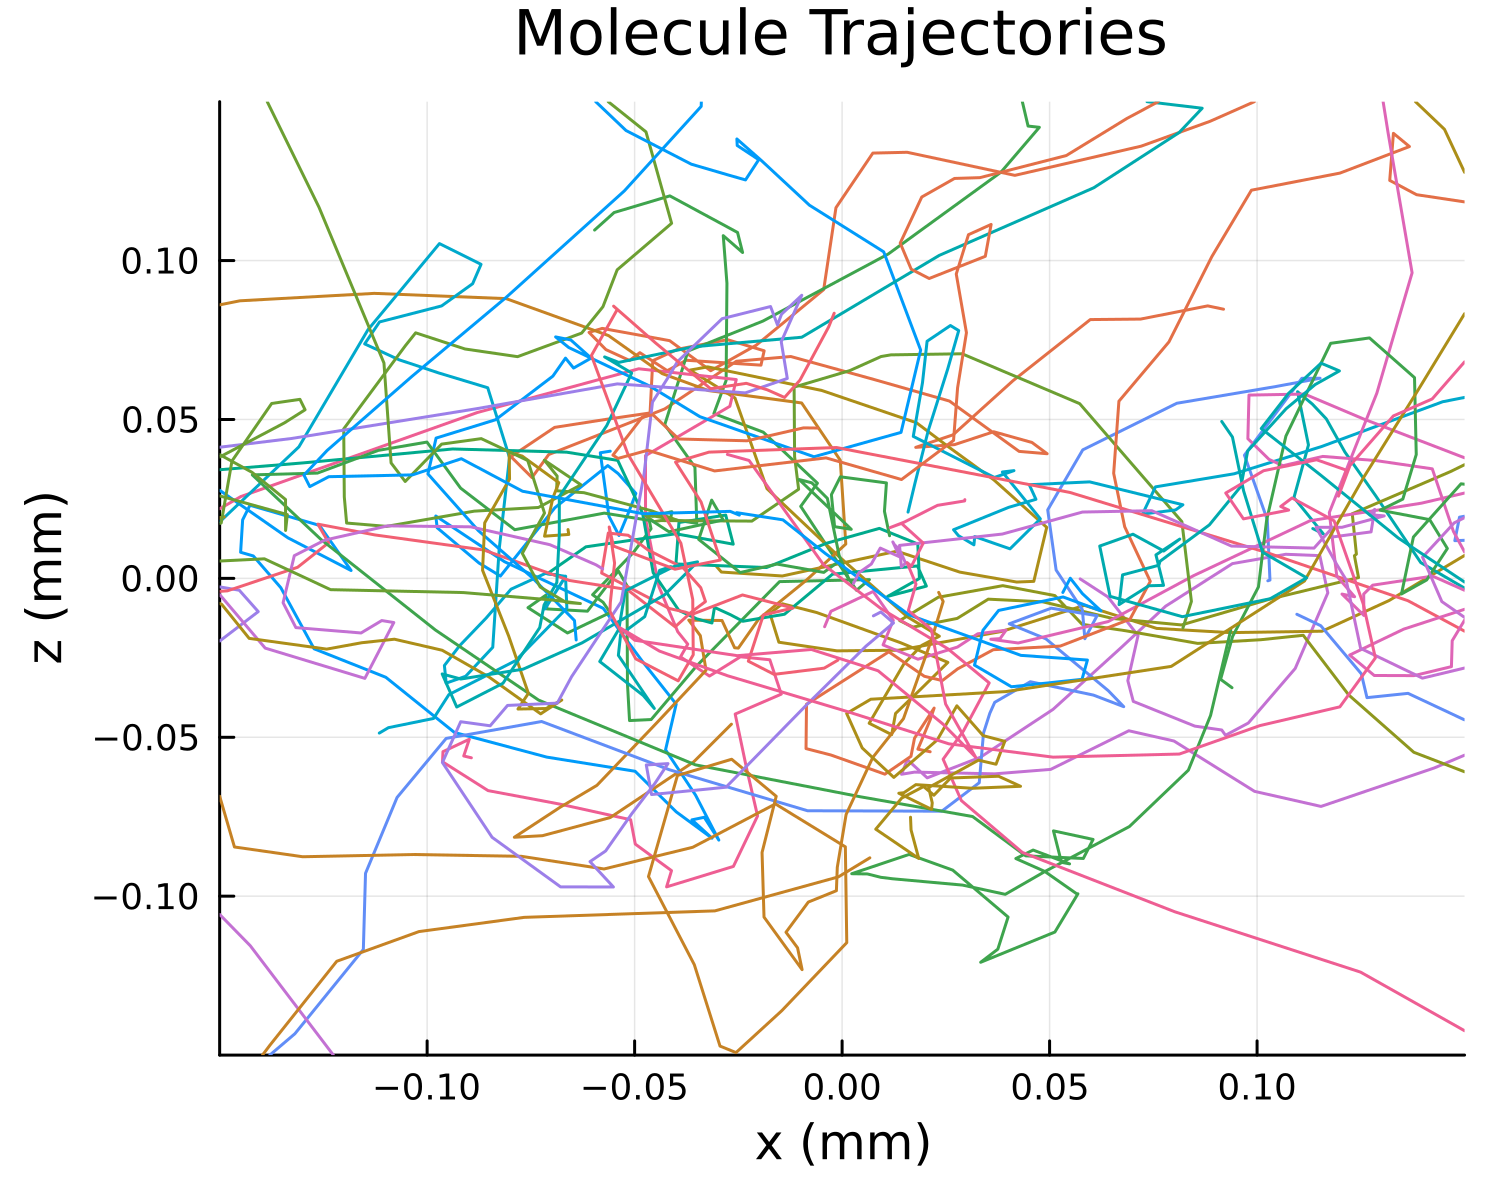

In [99]:
plot_lim = 0.15
plot(results.x_trajectories, results.z_trajectories, legend=false, xlim=[-plot_lim,plot_lim], ylim=[-plot_lim,plot_lim])
plot!(xlabel="x (mm)", ylabel="z (mm)", title="Molecule Trajectories", size=[500,400], dpi=300)
# savefig("C:\\Users\\Grace\\Desktop\\rasterODT.png")

In [90]:
println(plot_scattering_rate(results))

0.9467217516444494


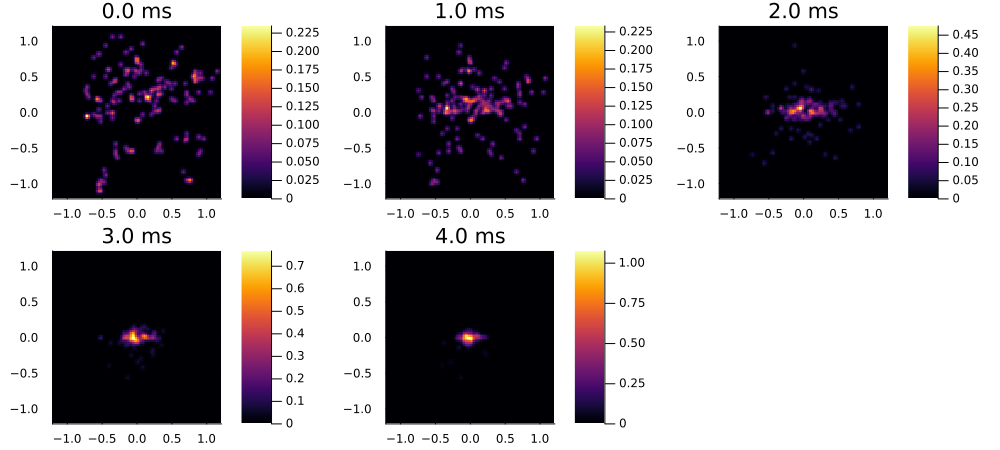

In [104]:
using ImageFiltering

ROI = 16e-3*300/2 / 2

img_duration = 2
# ROI = 2.0
n_pixels = 100

# ts = [0.0, 2, 4,  8,  12, 20]
ts = [0.0,1,2,3,4]
filter = 1
cmax = 2
plots = []
for t in ts
#     x, z, grids = make_2D_image(results,-ROI,ROI,n_pixels,t=t)
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=true, noise=0.00, photon_budget=14000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    push!(plots, heatmap(x,z,imgg', title=@sprintf("%.1f ms", t)))
end
plot(plots[1],plots[2],plots[3],plots[4],plots[5], size=(1000,450))
# savefig(joinpath(working_dir, @sprintf("test%i//camera_images.png", test_i)))
plot!()

In [7]:
function operator_matrix_expectation(O_Heisenberg, state)
    O_exp = 0.0 + 0.0im
    for i in 1:length(state)
       for j in 1: length(state)
            O_exp += O_Heisenberg[i,j] * conj(state[i]) * state[j]
        end
    end
    return O_exp
end

operator_matrix_expectation (generic function with 1 method)

In [5]:
using Optim

# Define the 2D Gaussian function
function gaussian2d(x, y, p)
    xc, yc, σx, σy, A = p
    return A * exp.(-((x .- xc) .^ 2 / (2 * σx^2) + (y .- yc) .^ 2 / (2 * σy^2)))
end


function least_sq_cost(params)
    predicted = [gaussian2d(xx, zz, params) for xx in x, zz in z]
    return sum((predicted - grids).^2)
end

using Optim
;

function get_trapped_indicies(param, results)
   t_max =  param.t_end*1e3
    trapped_indicies = Int[]
    for i in 1:length(results.times)
        if results.times[i][end] ≈ t_max
           push!(trapped_indicies, i) 
        end
    end
    return trapped_indicies
end;

function make_2D_image(results, x_min, x_max, n_pixels;t=0.0,photon_budget=Inf)
    """ grids = population """
    max_t_id = 1
     plot_ts = Float64[]
    for i in 1:length(results.times)
         if length(results.times[i]) > max_t_id
             max_t_id = length(results.times[i])  
             plot_ts = results.times[i]
         end                                                                                                          
     end
   dt = plot_ts[2] - plot_ts[1]
    it = Int(t ÷ dt) + 1

    grids = zeros(n_pixels, n_pixels)
    x = LinRange(x_min, x_max, n_pixels)
    dx = x[2]-x[1]
    z = LinRange(x_min, x_max, n_pixels)
    for i in 1:length(results.times)
        if it > length(results.times[i])
            continue
        end
        x_end = results.x_trajectories[i][it]
        z_end = results.z_trajectories[i][it]
        n_photons = sum(results.A_populations[i][1:it]*dt*Γ/1000)
       if  (x_min < x_end < x_max) && (x_min < z_end < x_max)
           ix = Int((x_end - x_min) ÷ dx + 1)
            iz = Int((z_end - x_min) ÷ dx + 1)
            grids[ix, iz] += 1 * exp(-n_photons / photon_budget)
        end
    end
    return x, z, grids
end

function take_camera_image(results, x_min, x_max, n_pixels;t=0.0, t_img=0.0, const_scattering=false, noise=0.0,photon_budget=Inf)
    x, z, grids = make_2D_image(results, x_min, x_max, n_pixels;t=t, photon_budget=photon_budget)
    dt = 0.5
    if const_scattering
        grids = grids .* dt 
    else
        grids = grids .* scattering_rate_at_t(results, t+0.1) * dt 
    end
    if t_img <= 0.5
        return x, z, grids
    else
        t_curr = t + dt
        while t_curr < t + t_img
            ~,~,grids1 = make_2D_image(results, x_min, x_max, n_pixels;t=t_curr, photon_budget=photon_budget)
            if const_scattering
                grids = grids .+ grids1 * dt
            else
                grids = grids .+ grids1 * scattering_rate_at_t(results, t_curr) * dt
            end
            t_curr += dt
        end
        grids = grids .+ (rand(length(x), length(z)).- 0.5).*t_img * noise
        return x, z, grids # grids = brightness
    end
end

function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        if r > 1.0
            n += 0.0
        elseif r > 0.5
            n += 0.1 * exp(-results.photons_scattered[survived_idx]/14000)
        elseif r > 0.3
            n += (0.6 - r)* exp(-results.photons_scattered[survived_idx]/14000)
        elseif r <= 0.3
            n += ((0.3 - r) * 3 + 0.3) * exp(-results.photons_scattered[survived_idx]/14000)
        end
    end
    return n/n_molecules
end
;
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if abs(times[i][end] - t_end*1e3) <= 1.0
            push!(_survived, i)
        end
    end
    return _survived
end;
function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end
;